# **ResNet18 with CIFAR-10 — 학습/추론/시각화**

## 학습 목표
- Residual Connection(잔차 연결)의 구조와 원리를 이해하고, ResNet-18 모델을 CIFAR-10 이미지 분류 작업에 맞게 구현 및 최적화할 수 있도록 실습합니다.
- 데이터 전처리부터 모델 학습, 성능 평가, 그리고 Class Activation Map(CAM) 등을 활용한 추론 결과 시각화까지의 ResNet 파이프라인 전 과정을 익힙니다.

---

### 구성 개요
1. **CIFAR-10 로드** + 입력 이미지 크기 확인
2. **ResNet18(CIFAR-friendly)** 구성
3. **학습(Training)** + 체크포인트 저장/재개(있으면 +10 epoch, 없으면 20 epoch)
4. **추론(Inference)** + 예측/신뢰도 확인
5. **Confusion Matrix / 클래스별 정확도 / 오분류 샘플** 분석
6. **Activation Map** 시각화 (layer1 vs layer4 비교)
7. **Conv Kernel** 시각화 (초기/중간 레이어)
8. **Grad-CAM** 시각화 (Top-K 정분류 + Top-K 오분류: 원본과 Overlay 함께)
9. (추가 실습) **Receptive Field** 근사 계산 + 의미 설명
10. (추가 실습) **Embedding(t-SNE)** 시각화
11. (추가 실습) **ONNX Export + 모델 구조 출력** (Netron 비교용)

> 권장 실행: 위에서 아래로 순차 실행


---
## 0) Setup (환경 준비)
- **목적:** 실습에 필요한 패키지를 로드하고, 디바이스를 출력합니다.
- **관찰 포인트**
  - 실습에 필요한 유틸 패키지(`torch`, `torchvision`, `matplotlib`, `onnx` 등) 준비
  - GPU 사용 여부(`cuda`)와 제품명 확인

In [1]:
import importlib.util
import subprocess
import sys

def ensure_package(pkg_name: str, import_name=None):
    """
    패키지 설치 여부를 확인하고, 설치되어 있지 않으면 설치합니다.
    """
    name = import_name or pkg_name
    # 패키지가 설치되어 있는지 확인
    if importlib.util.find_spec(name) is None:
        print(f"[install] {pkg_name} 라이브러리를 설치 중입니다... (import name: {name})")
        try:
            # -q 옵션을 추가하여 설치 과정을 간결하게 유지할 수 있습니다.
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg_name])
            print(f"[success] {pkg_name} 설치 완료.")
        except subprocess.CalledProcessError as e:
            print(f"[error] {pkg_name} 설치 실패: {e}")
    else:
        print(f"[ok] {pkg_name} 이미 설치되어 있습니다.")

# 설치가 필요한 패키지 리스트 (패키지명, 임포트명)
# 임포트명이 패키지명과 다른 경우 튜플로 지정합니다.
packages = [
    ("torch", "torch"),
    ("torchvision", "torchvision"),
    ("matplotlib", "matplotlib"),
    ("onnx", "onnx"),
]

# 루프를 돌며 확인 및 설치
for pkg, imp in packages:
    ensure_package(pkg, imp)

[ok] torch 이미 설치되어 있습니다.
[ok] torchvision 이미 설치되어 있습니다.
[ok] matplotlib 이미 설치되어 있습니다.
[ok] onnx 이미 설치되어 있습니다.


In [2]:
import os  # path/환경 확인
import random  # seed 고정
import time  # epoch 시간 측정
import numpy as np  # 수치 계산
import torch  # PyTorch 본체
import torch.nn as nn  # 모델 레이어
import torch.nn.functional as F  # softmax 등 함수
from torch.utils.data import DataLoader  # 데이터 로더
import torchvision  # vision dataset/util
import torchvision.transforms as T  # transform
import torchvision.models as models  # resnet18
import matplotlib.pyplot as plt  # 시각화

print('torch:', torch.__version__)  # torch 버전 출력
print('torchvision:', torchvision.__version__)  # torchvision 버전 출력
print('cuda available:', torch.cuda.is_available())  # GPU 사용 가능 여부
if torch.cuda.is_available():
    print('gpu:', torch.cuda.get_device_name(0))  # GPU 이름 출력

try:
    get_ipython().system('nvidia-smi -L')  # GPU 목록 확인(가능한 경우)
except Exception as e:
    print('nvidia-smi not available:', e)  # nvidia-smi가 없는 환경이면 무시

def seed_everything(seed: int = 42):
    random.seed(seed)  # python random seed
    np.random.seed(seed)  # numpy seed
    torch.manual_seed(seed)  # torch CPU seed
    torch.cuda.manual_seed_all(seed)  # torch GPU seed
    torch.backends.cudnn.deterministic = False  # 성능 우선(완전 재현성 X)
    torch.backends.cudnn.benchmark = True  # 입력 크기 고정이면 속도 향상

seed_everything(42)  # seed 고정(실험 재현성)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 실행 디바이스 선택
device  # 디바이스 출력


torch: 2.5.1
torchvision: 0.20.1+cpu
cuda available: True
gpu: NVIDIA A10-24Q
GPU 0: NVIDIA A10-24Q (UUID: GPU-34aa1680-eaf3-11f0-807d-2e835fe645ba)


device(type='cuda')

---
## 1) Dataset: CIFAR-10 로드 + 입력 크기 확인
- **목적:** 학습/평가에 사용할 데이터셋을 준비합니다.
- **관찰 포인트**
    - CNN 입력은 **(C,H,W)** 텐서이며, CIFAR-10은 **32×32** 입니다.
    - augmentation(RandomCrop/Flip)을 적용합니다.
    - CIFAR-10 데이터셋 구성
       - Number of Classes: 10 (e.g., airplane, dog, cat, frog, etc.)
       - Image Distribution: The dataset is class-balanced, with 6,000 images per class (5,000 for training and 1,000 for testing).
       - Image Format: All images are 32x32 pixel color images (3 RGB channels).

In [3]:
# CIFAR-10에서 널리 쓰는 normalize 값
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)  # 채널별 평균(R,G,B)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)  # 채널별 표준편차(R,G,B)

train_tfms = T.Compose([  # train transform(augmentation 포함)
    T.RandomCrop(32, padding=4),  # 32x32를 padding 후 random crop
    T.RandomHorizontalFlip(),  # 좌우 반전
    T.ToTensor(),  # PIL -> torch tensor (C,H,W), 0~1
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),  # 정규화, -2.5~2.5
])

test_tfms = T.Compose([  # test transform(augmentation 없음)
    T.ToTensor(),  # 텐서 변환
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),  # 정규화
])

data_root = './data'  # 데이터 저장 경로
train_set = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tfms)  # train set
test_set  = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)  # test set

class_names = train_set.classes  # 클래스 이름 목록
num_classes = len(class_names)  # 클래스 개수(10)
print('classes:', class_names)  # 클래스 출력

# 이미지 사이즈 출력
x0, y0 = train_set[0]  # 한 샘플 로드(이미 transform 적용된 텐서)
print('Sample image tensor shape (C,H,W):', tuple(x0.shape))  # (3,32,32)

batch_size = 256  # 배치 크기
num_workers = min(8, os.cpu_count() or 2)  # dataloader worker 수(환경에 맞게)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)  # train loader
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)  # test loader

print('Total batch size (train: %d, test: %d)' % (len(train_loader), len(test_loader)))  # 배치 개수 확인


Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Sample image tensor shape (C,H,W): (3, 32, 32)
Total batch size (train: 196, test: 40)


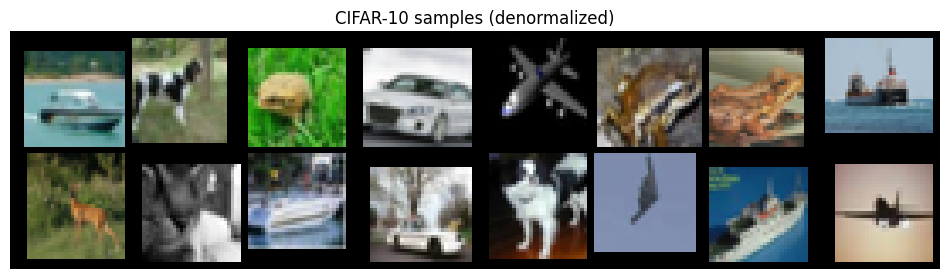

labels: ['ship', 'dog', 'frog', 'automobile', 'airplane', 'frog', 'frog', 'ship', 'deer', 'cat', 'ship', 'automobile', 'dog', 'airplane', 'ship', 'airplane']


In [4]:

def denorm(x): # -2.5~2.5
    mean = torch.tensor(CIFAR10_MEAN).view(1,3,1,1)  # (1,3,1,1) 형태로 broadcast
    std  = torch.tensor(CIFAR10_STD).view(1,3,1,1)  # (1,3,1,1) 형태로 broadcast
    return x * std + mean  # 정규화 역변환, 0~1

images, labels = next(iter(train_loader))  # 한 배치 가져오기
images_dn = denorm(images[:16]).clamp(0,1)  # 앞 16장만 역정규화 후 [0,1]로 clip

grid = torchvision.utils.make_grid(images_dn, nrow=8)  # 그리드로 묶기(C,H,W)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1,2,0))  # CHW -> HWC 로 변환 후 표시
plt.axis('off')
plt.title('CIFAR-10 samples (denormalized)')
plt.show()

print('labels:', [class_names[int(x)] for x in labels[:16]])  # 라벨 이름 출력


---
## 2) ResNet18 모델 준비
- **목적:** CIFAR-10(32×32)에 맞는 ResNet18을 구성합니다.
- **관찰 포인트**
    - ImageNet용 stem(7×7 stride 2 + maxpool)은
      - `conv1`을 **3×3 stride 1**로 바꾸고
      - `maxpool`을 제거합니다.


In [5]:
def build_resnet18_for_cifar10(num_classes: int = 10):
    model = models.resnet18(weights=None)  # ImageNet pretrained 없이 ResNet18 생성 (from scratch)
    print("\n" + "="*40)
    print("=== PyTorch model structure (Before) ===")  # 모델 구조 출력
    print("="*40 + "\n")
    print(model)  # 구조 출력

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # CIFAR용 stem
    model.maxpool = nn.Identity()  # maxpool 제거
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # 최종 분류기 출력=10
    return model

model = build_resnet18_for_cifar10(num_classes).to(device)  # 모델 생성 후 device 이동

print("\n" + "="*40)
print("=== PyTorch model structure (After) ===")  # 모델 구조 출력
print("="*40 + "\n")
print(model)  # 구조 출력

num_params = sum(p.numel() for p in model.parameters())  # 파라미터 개수
print(f'params: {num_params:,}')  # 출력



=== PyTorch model structure (Before) ===

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

---
## 3) 학습 유틸리티
- **목적:** 학습/평가 루프를 재사용 가능하게 만들어 실험을 단순화합니다.
- **관찰 포인트**
  - `model.train()` vs `model.eval()` 차이
  - AMP(Automatic Mixed Precision) 사용
     - 계산이 복잡한 곳은 FP32를 쓰고, 단순한 곳은 FP16을 섞어서 사용
     - GradScaler의 역할: FP16을 쓰면 기울기(Gradient) 값이 너무 작아져서 사라질 위험이 있음 (언더플로우)
        - Scaling: 손실(Loss) 값에 아주 큰 값을 곱해 기울기를 크게 키움
        - Backprop: 커진 상태로 역전파를 수행하여 값이 사라지지 않게 보호
        - Unscaling: 업데이트 직전에 다시 원래 비율로 줄여서 가중치에 반영


In [6]:
from dataclasses import dataclass  # 설정을 깔끔하게 묶기 위한 dataclass

@dataclass
class TrainConfig:
    base_epochs_if_new: int = 20  # 처음 실험 시 epoch 수
    extra_epochs_if_resume: int = 10  # 체크포인트 존재 시 추가 실험 epoch 수
    lr: float = 0.1  # learning rate
    weight_decay: float = 5e-4  # L2 정규화
    momentum: float = 0.9  # SGD momentum
    label_smoothing: float = 0.0  # 필요 시 label smoothing, 예) [0, 1, 0] ->  [0.05, 0.9, 0.05]

cfg = TrainConfig()  # config 인스턴스 생성

def accuracy_top1(logits, targets):
    preds = logits.argmax(dim=1)  # 가장 큰 logit의 클래스 선택, logits = [B, C], preds = [B]
    return (preds == targets).float().mean().item()  # top-1 accuracy, scalar

scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())  # AMP용 scaler, 학습 속도를 높이고 메모리 사용량을 줄임
print(scaler)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()  # train mode(dropout/bn 동작 변경)
    total_loss, total_acc = 0.0, 0.0  # 누적 loss/acc
    n = 0  # 샘플 수 누적
    t0 = time.time()  # 시간 측정 시작
    for images, labels in loader:
        images = images.to(device, non_blocking=True)  # 입력을 GPU로 이동 (Asynchronous transfer)
        labels = labels.to(device, non_blocking=True)  # 라벨을 GPU로 이동 (Asynchronous transfer)

        optimizer.zero_grad(set_to_none=True)  # gradient 초기화
        with torch.amp.autocast(device_type=device.type, enabled=torch.cuda.is_available()):  # AMP autocast
            logits = model(images)  # forward
            loss = criterion(logits, labels)  # loss 계산
        scaler.scale(loss).backward()  # scaled backward
        scaler.step(optimizer)  # optimizer step
        scaler.update()  # scaler 업데이트

        bs = images.size(0)  # batch size
        total_loss += loss.item() * bs  # batch loss 누적
        total_acc  += accuracy_top1(logits.detach(), labels) * bs  # logits값만 복사, batch acc 누적
        n += bs  # 샘플 수 누적

    dt = time.time() - t0  # epoch 수행 시간
    return total_loss / n, total_acc / n, dt  # 평균 loss/acc/시간

@torch.no_grad()   # Autograd off, 함수 내부에서 기울기 계산 멈춤
def evaluate(model, loader, criterion):
    model.eval()  # eval mode, i.e., Dropout 비활성화, BN Running Stats 고정
    total_loss, total_acc = 0.0, 0.0  # 누적
    n = 0  # 샘플 수
    for images, labels in loader:
        images = images.to(device, non_blocking=True)  # GPU 이동
        labels = labels.to(device, non_blocking=True)  # GPU 이동
        logits = model(images)  # forward
        loss = criterion(logits, labels)  # loss
        bs = images.size(0)  # batch size
        total_loss += loss.item() * bs  # 누적
        total_acc  += accuracy_top1(logits, labels) * bs  # 누적
        n += bs  # 누적
    return total_loss / n, total_acc / n  # 평균 loss/acc

def plot_history(hist):
    epochs = np.arange(1, len(hist['train_loss'])+1)  # epoch index
    plt.figure(figsize=(12,4))
    plt.plot(epochs, hist['train_loss'], label='train_loss')  # train loss
    plt.plot(epochs, hist['val_loss'], label='val_loss')  # val loss
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(epochs, hist['train_acc'], label='train_acc')  # train acc
    plt.plot(epochs, hist['val_acc'], label='val_acc')  # val acc
    plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.grid(True)
    plt.show()


---
## 4) ResNet18 학습
- **목적:** CIFAR-10에서 ResNet18을 학습하고, 가장 좋은 성능의 모델을 저장합니다.
- **관찰 포인트**
    - `resnet18_cifar10.pth`가 있으면 **그 모델을 로드**하고 **10 epoch만 추가 학습**합니다.
    - 파일이 없으면 **20 epoch 학습**합니다.
    - 체크포인트로 실험을 이어갈 수 있다는 점


Found checkpoint. Resume from epoch 50 (best val_acc=0.9370). Train +10 epochs.
Epoch 051 | lr 0.1000 | train loss 0.2774 acc 0.9062 | val loss 0.5943 acc 0.8191 | 37.4s
Epoch 052 | lr 0.0976 | train loss 0.2560 acc 0.9114 | val loss 0.4263 acc 0.8650 | 36.9s
Epoch 053 | lr 0.0905 | train loss 0.2296 acc 0.9203 | val loss 0.5916 acc 0.8145 | 37.1s
Epoch 054 | lr 0.0794 | train loss 0.1970 acc 0.9315 | val loss 0.4853 acc 0.8506 | 37.7s
Epoch 055 | lr 0.0655 | train loss 0.1573 acc 0.9458 | val loss 0.3795 acc 0.8833 | 36.5s
Epoch 056 | lr 0.0500 | train loss 0.1236 acc 0.9580 | val loss 0.3293 acc 0.8993 | 36.7s
Epoch 057 | lr 0.0345 | train loss 0.0827 acc 0.9721 | val loss 0.2803 acc 0.9142 | 36.7s
Epoch 058 | lr 0.0206 | train loss 0.0559 acc 0.9816 | val loss 0.2298 acc 0.9304 | 36.7s
Epoch 059 | lr 0.0095 | train loss 0.0337 acc 0.9899 | val loss 0.2104 acc 0.9363 | 36.7s
Epoch 060 | lr 0.0024 | train loss 0.0269 acc 0.9921 | val loss 0.2041 acc 0.9365 | 37.1s
Best val acc: 0.937


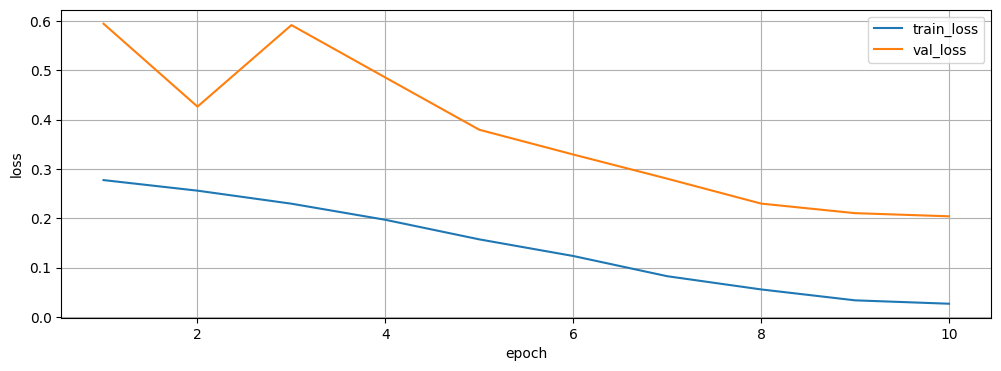

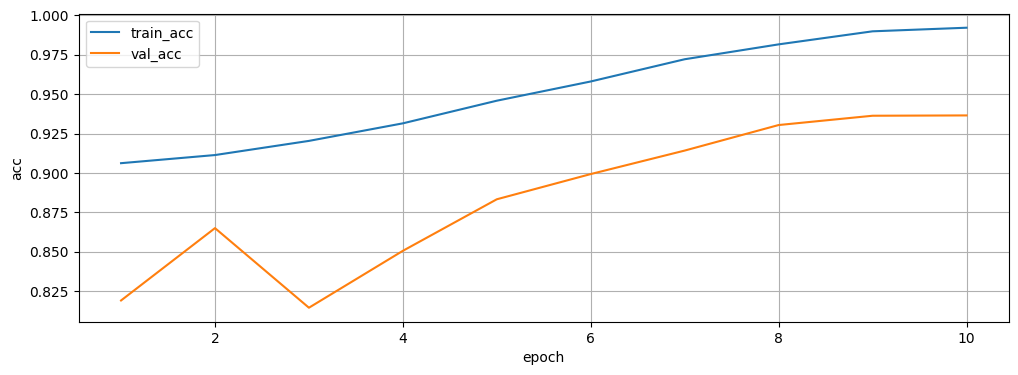

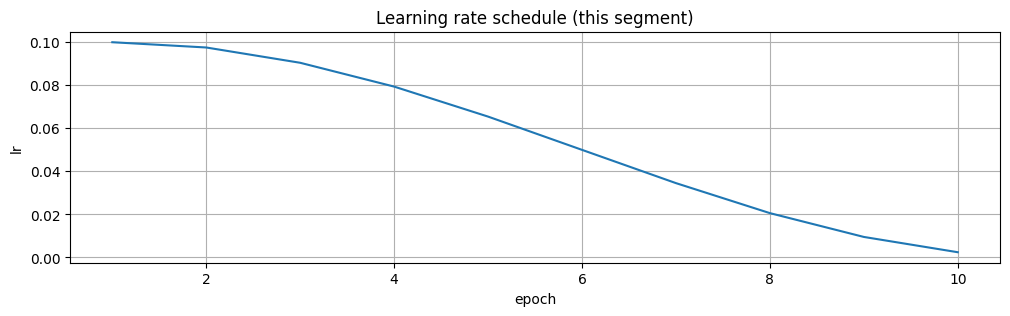

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)  # 분류 loss
optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)  # Mini-Batch SGD optimizer with Momentum

ckpt_path = 'resnet18_cifar10.pth'  # best checkpoint 경로
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}  # 기록용 dict

start_epoch = 0  # resume 시작 epoch
best_acc = -1.0  # best val acc

if os.path.exists(ckpt_path):  # 체크포인트가 있으면 resume
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=True)  # checkpoint 로드
    model.load_state_dict(ckpt['model'])  # 모델 가중치 로드
    start_epoch = int(ckpt.get('epoch', 0))  # 저장된 epoch
    best_acc = float(ckpt.get('val_acc', -1.0))  # 저장된 best acc
    epochs_to_run = cfg.extra_epochs_if_resume  # 추가 실험 epoch = 10
    print(f"Found checkpoint. Resume from epoch {start_epoch} (best val_acc={best_acc:.4f}). Train +{epochs_to_run} epochs.")
else:  # 체크포인트가 없으면 처음부터
    epochs_to_run = cfg.base_epochs_if_new  # 신규 실험 epoch = 20
    print(f"No checkpoint. Train {epochs_to_run} epochs from scratch.")

# 학습률을 T_max에 맞춰 코사인 곡선 형태로 변화
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_to_run)  # 이번 실험 구간에 대해 cosine schedule

for e in range(1, epochs_to_run+1):
    epoch = start_epoch + e  # 실제 epoch 번호(누적)
    lr_now = optimizer.param_groups[0]['lr']  # 현재 lr, [ { 'params': [...], 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0005, ... } ]
    tr_loss, tr_acc, dt = train_one_epoch(model, train_loader, optimizer, criterion)  # 1 epoch train
    va_loss, va_acc = evaluate(model, test_loader, criterion)  # validation
    scheduler.step()  # lr 스케줄 업데이트

    history['train_loss'].append(tr_loss)  # 기록
    history['train_acc'].append(tr_acc)  # 기록
    history['val_loss'].append(va_loss)  # 기록
    history['val_acc'].append(va_acc)  # 기록
    history['lr'].append(lr_now)  # 기록

    print(f"Epoch {epoch:03d} | lr {lr_now:.4f} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f} | {dt:.1f}s")

    if va_acc > best_acc:  # best 갱신 시 저장
        best_acc = va_acc  # best 업데이트
        torch.save({'model': model.state_dict(), 'epoch': epoch, 'val_acc': va_acc, 'config': cfg.__dict__}, ckpt_path)  # 체크포인트 저장
        print(f"  Saved best checkpoint: {ckpt_path} (val_acc={va_acc:.4f})")

print('Best val acc:', best_acc)  # best 출력
plot_history(history)  # 실험 곡선

plt.figure(figsize=(12,3))
plt.plot(np.arange(1, epochs_to_run+1), history['lr'])  # lr 변화(이번 구간)
plt.xlabel('epoch'); plt.ylabel('lr'); plt.title('Learning rate schedule (this segment)'); plt.grid(True)
plt.show()


---
## 5) 추론(Inference)
- **목적:** 학습된 모델이 실제로 어떤 클래스로 예측하는지 확인합니다.
- **관찰 포인트**
    - softmax 확률과 confidence(최대 확률)


Loaded checkpoint epoch: 50 val_acc: 0.937


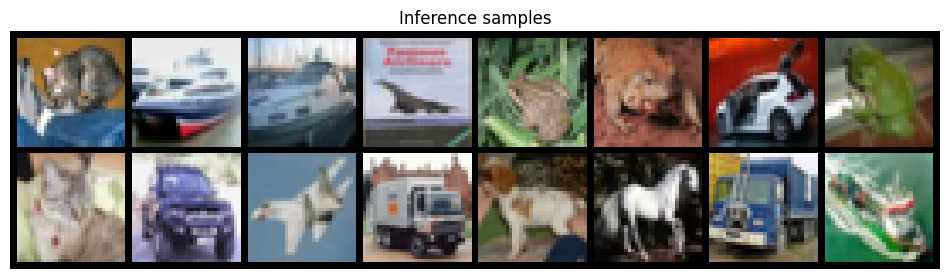

[00] GT=       cat | Pred=       cat | conf=1.000
[01] GT=      ship | Pred=      ship | conf=1.000
[02] GT=      ship | Pred=      ship | conf=0.998
[03] GT=  airplane | Pred=  airplane | conf=0.982
[04] GT=      frog | Pred=      frog | conf=1.000
[05] GT=      frog | Pred=      frog | conf=0.998
[06] GT=automobile | Pred=automobile | conf=0.992
[07] GT=      frog | Pred=      frog | conf=0.999
[08] GT=       cat | Pred=       cat | conf=1.000
[09] GT=automobile | Pred=automobile | conf=0.999
[10] GT=  airplane | Pred=  airplane | conf=1.000
[11] GT=     truck | Pred=     truck | conf=1.000
[12] GT=       dog | Pred=       dog | conf=0.996
[13] GT=     horse | Pred=     horse | conf=1.000
[14] GT=     truck | Pred=     truck | conf=1.000
[15] GT=      ship | Pred=      ship | conf=0.860


In [8]:
ckpt = torch.load(ckpt_path, map_location=device, weights_only=True)  # best checkpoint 로드
model.load_state_dict(ckpt['model'])  # 최신 모델 가중치 적용
model.eval()  # eval 모드, i.e., Dropout 비활성화, BN Running Stats 고정
print('Loaded checkpoint epoch:', ckpt.get('epoch'), 'val_acc:', ckpt.get('val_acc'))  # 정보 출력

@torch.no_grad()  # 자동 미분(Autograd) 기능 비활성화
def predict_batch(model, images):
    logits = model(images)  # raw logits
    probs = F.softmax(logits, dim=1)  # 확률로 변환
    conf, pred = probs.max(dim=1)  # 최대 확률(conf)과 클래스(pred)
    return pred, conf, probs

images, labels = next(iter(test_loader))  # test 배치 하나
images = images.to(device)  # GPU 이동
labels = labels.to(device)  # GPU 이동
pred, conf, probs = predict_batch(model, images)  # 예측

k = 16  # 시각화 샘플 수
imgs_dn = denorm(images[:k].cpu()).clamp(0,1)  # 역정규화

grid = torchvision.utils.make_grid(imgs_dn, nrow=8)  # 그리드
plt.figure(figsize=(12,6))
plt.imshow(grid.permute(1,2,0))  # HWC로 변환
plt.axis('off')
plt.title('Inference samples')
plt.show()

for i in range(k):
    gt = class_names[int(labels[i])]  # 정답 클래스명
    pr = class_names[int(pred[i])]  # 예측 클래스명
    cf = float(conf[i])  # confidence
    print(f"[{i:02d}] GT={gt:>10s} | Pred={pr:>10s} | conf={cf:.3f}")  # 출력


---
## 6) 성능 분석: Confusion Matrix / 클래스별 정확도 / 오분류 샘플
- **목적:** 단순 overall accuracy 말고, **어떤 클래스가 서로 헷갈리는지**를 분석합니다.
- **관찰 포인트**
  - Confusion Matrix에서 off-diagonal가 큰 위치 = 헷갈리는 클래스 쌍
  - 클래스별 accuracy로 데이터/모델의 약점 찾기


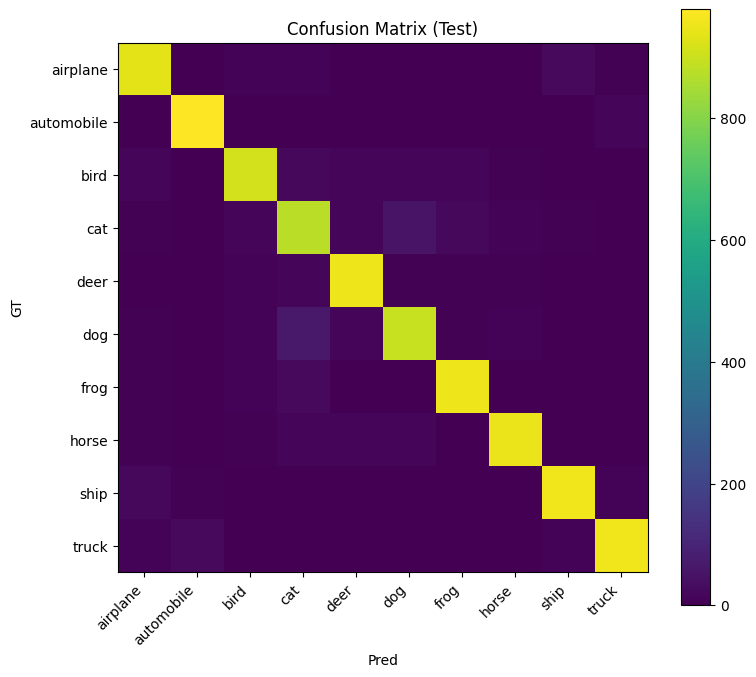

Per-class accuracy:
  airplane: 0.939
automobile: 0.978
      bird: 0.911
       cat: 0.875
      deer: 0.952
       dog: 0.896
      frog: 0.954
     horse: 0.950
      ship: 0.958
     truck: 0.957
num misclassified: 630


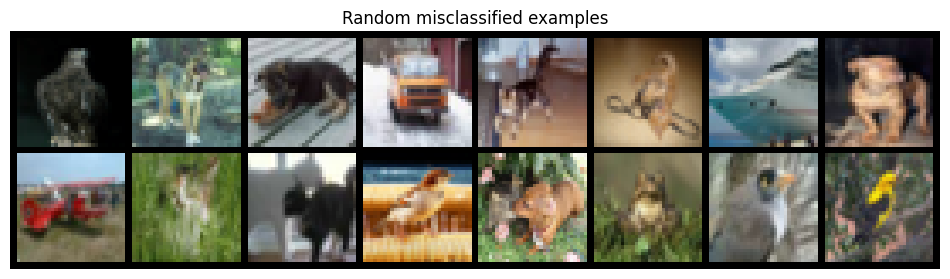

[00] idx=  118 GT=      bird Pred=      frog
[01] idx= 9369 GT=       dog Pred=      deer
[02] idx= 8212 GT=       dog Pred=       cat
[03] idx= 2186 GT=     truck Pred=automobile
[04] idx= 4485 GT=       cat Pred=     horse
[05] idx= 6202 GT=       cat Pred=      bird
[06] idx=  665 GT=      ship Pred=  airplane
[07] idx= 4998 GT=       dog Pred=      frog
[08] idx= 8993 GT=  airplane Pred=     truck
[09] idx=  456 GT=       cat Pred=      deer
[10] idx= 8362 GT=       cat Pred=       dog
[11] idx= 1150 GT=      bird Pred=      deer
[12] idx= 7002 GT=       cat Pred=      deer
[13] idx= 5534 GT=      frog Pred=       cat
[14] idx= 7395 GT=      bird Pred=       cat
[15] idx= 5839 GT=      bird Pred=      frog


In [9]:
@torch.no_grad()
def collect_predictions(model, loader):
    model.eval()  # eval 모드
    all_preds, all_labels, all_images = [], [], []  # 누적 리스트
    for images, labels in loader:
        images = images.to(device)  # GPU 이동
        labels = labels.to(device)  # GPU 이동
        preds, conf, _ = predict_batch(model, images)  # 예측
        all_preds.append(preds.cpu())  # CPU로 모아두기
        all_labels.append(labels.cpu())  # CPU로 모아두기
        all_images.append(images.cpu())  # 이미지도 저장(오분류 시각화용)
    return torch.cat(all_images), torch.cat(all_preds), torch.cat(all_labels)  # 전체 텐서로 결합

def confusion_and_perclass(preds, labels, num_classes):
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)  # confusion matrix 초기화
    for t, p in zip(labels, preds):
        cm[int(t), int(p)] += 1  # GT=t, Pred=p 카운트 증가
    per_class_acc = cm.diagonal().float() / torch.clamp(cm.sum(dim=1).float(), min=1.0)  # 클래스별 정확도
    return cm, per_class_acc

images_all, preds_all, labels_all = collect_predictions(model, test_loader)  # test 전체 예측 수집
cm, pacc = confusion_and_perclass(preds_all, labels_all, num_classes)  # confusion + per-class

plt.figure(figsize=(8,7))
plt.imshow(cm.numpy())  # confusion matrix 이미지화
plt.title('Confusion Matrix (Test)')
plt.xlabel('Pred'); plt.ylabel('GT')
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

print('Per-class accuracy:')
for i, a in enumerate(pacc.tolist()):
    print(f"{class_names[i]:>10s}: {a:.3f}")  # 클래스별 정확도 출력

# 오분류 샘플 랜덤 16개 표시
mis_idx = (preds_all != labels_all).nonzero(as_tuple=False).squeeze(1)  # 오분류 인덱스, squeeze(1) : 1번째 인덱스 차원 제거
print('num misclassified:', int(mis_idx.numel()))  # 오분류 개수
if mis_idx.numel() > 0:
    sel = mis_idx[torch.randperm(mis_idx.numel())[:16]]  # 랜덤 16개 선택
    imgs = denorm(images_all[sel]).clamp(0,1)  # 역정규화
    grid = torchvision.utils.make_grid(imgs, nrow=8)  # 그리드
    plt.figure(figsize=(12,5))
    plt.imshow(grid.permute(1,2,0))  # 표시
    plt.axis('off')
    plt.title('Random misclassified examples')
    plt.show()

    for j, idx in enumerate(sel.tolist()):
        gt = class_names[int(labels_all[idx])]  # GT
        pr = class_names[int(preds_all[idx])]  # Pred
        print(f"[{j:02d}] idx={idx:5d} GT={gt:>10s} Pred={pr:>10s}")  # 출력


---
## 7) Activation Map 시각화 (채널별)
- **목적:** CNN의 **각 레이어**가 무엇을 보는지 시각적으로 확인합니다.
- **관찰 포인트**
  - `layer1~2`: 엣지/텍스처처럼 로컬 패턴이 자주 보임
  - `layer3~4`: 더 의미적인(부품/영역) 반응이 나오는 경향

> 구현 방법: 원하는 레이어에 **forward hook**을 걸어 feature map(B,C,H,W)을 받아옵니다.


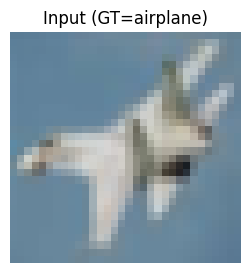

Layer Name           | Activation Shape
---------------------------------------------
layer1.1.conv2       | (64, 32, 32)


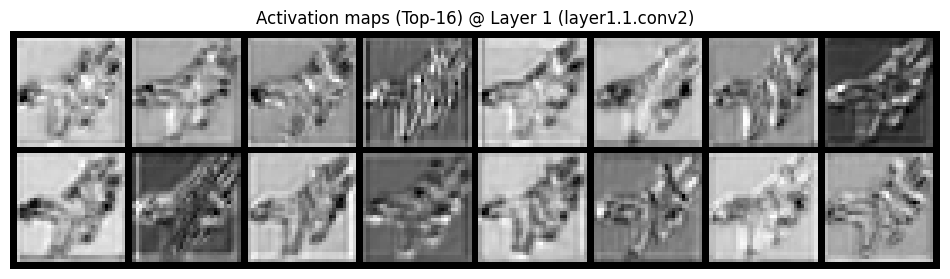

layer2.1.conv2       | (128, 16, 16)


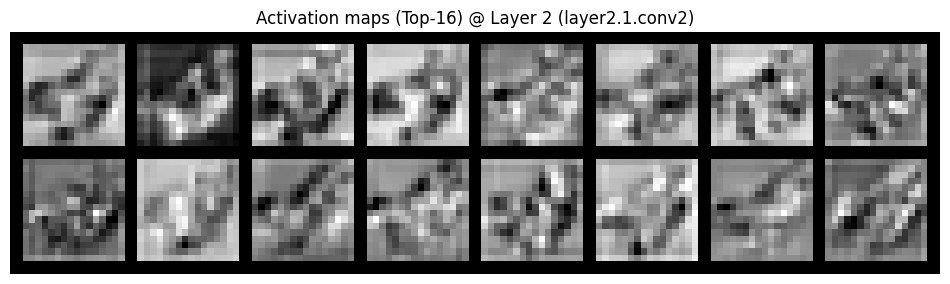

layer3.1.conv2       | (256, 8, 8)


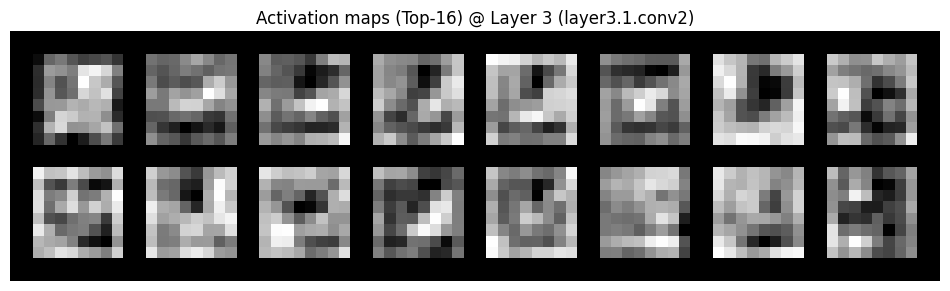

layer4.1.conv2       | (512, 4, 4)


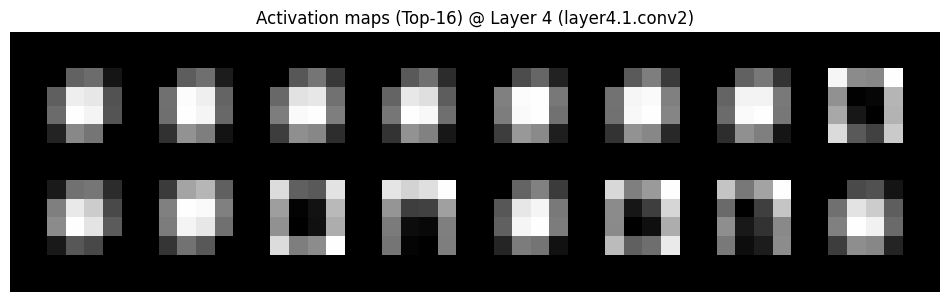

In [10]:
def get_module_by_name(model: nn.Module, name: str) -> nn.Module:
    cur = model  # 시작 모듈
    for part in name.split('.'):  # 점(.) 기준으로 순회
        if part.isdigit():
            cur = cur[int(part)]  # Sequential 인덱스 접근
        else:
            cur = getattr(cur, part)  # attribute 접근
    return cur

def capture_activation(model, layer_name, x_single):
    layer = get_module_by_name(model, layer_name)  # target layer
    activ = {}  # 저장용 dict
    def hook(m, i, o):  # callback function
        activ['feat'] = o.detach().cpu()  # (B,C,H,W) 저장

    h = layer.register_forward_hook(hook)  # target layer처리시 forward hook 등록 (hook 함수 실행)
    model.eval()  # eval 모드
    with torch.no_grad():
        _ = model(x_single)  # forward 수행
    h.remove()  # hook 제거
    assert 'feat' in activ, f"Hook failed for layer {layer_name}"  # 방어 코드
    return activ['feat'][0]  # (C,H,W) 반환

def show_topk_activation_grid(feat_chw, title, topk=16):
    ch_scores = feat_chw.abs().mean(dim=(1,2))  # 채널별 평균 크기 점수
    idx = torch.topk(ch_scores, k=min(topk, feat_chw.shape[0])).indices  # Top-K 채널 인덱스
    maps = []  # (K,1,H,W)로 만들 리스트
    for ci in idx:
        m = feat_chw[int(ci)]  # (H,W)
        m = (m - m.min()) / (m.max() - m.min() + 1e-6)  # 0~1 정규화
        maps.append(m[None, None, ...])  # (1,1,H,W)
    maps = torch.cat(maps, dim=0)  # (K,1,H,W)
    grid = torchvision.utils.make_grid(maps, nrow=8, padding=2)  # grid 생성(종종 3채널로 변환되기도 함)
    plt.figure(figsize=(12,5))
    if grid.ndim == 3 and grid.shape[0] in (3, 4):  # (3,H,W)면 HWC로 변환
        plt.imshow(grid.permute(1,2,0))
    else:  # (1,H,W)면 2D로 표시
        plt.imshow(grid.squeeze(0), cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()


# 1. 시각화할 레이어 이름 정의 (ResNet 구조 기준)
target_layers = {
    "Layer 1": "layer1.1.conv2", # 얕은 레이어
    "Layer 2": "layer2.1.conv2",
    "Layer 3": "layer3.1.conv2",
    "Layer 4": "layer4.1.conv2"  # 깊은 레이어
}

# 2. 입력 이미지 선택(원하면 idx 변경)
idx = 10  # 샘플 인덱스
x, y = test_set[idx]   # 샘플 로드
x_in = x.unsqueeze(0).to(device)

img0 = denorm(x.unsqueeze(0)).squeeze(0).clamp(0,1)
plt.figure(figsize=(3,3))
plt.imshow(img0.permute(1,2,0))
plt.title(f'Input (GT={class_names[y]})')
plt.axis('off')
plt.show()

# 3. 반복문을 통해 각 레이어의 Activation 추출 및 시각화
print(f"{'Layer Name':<20} | {'Activation Shape'}")
print("-" * 45)

for title, layer_name in target_layers.items():
    # Activation 캡처
    feat = capture_activation(model, layer_name, x_in)

    # 정보 출력
    print(f"{layer_name:<20} | {tuple(feat.shape)}") # (C,H,W)

    # 시각화 (Top-16 채널)
    show_topk_activation_grid(feat, f'Activation maps (Top-16) @ {title} ({layer_name})', topk=16)


---
## 8) Convolution Kernel 시각화
- **목적:** convolution filter가 학습되면서 어떤 형태(엣지/방향성 등)를 띠는지 확인합니다.
- **관찰 포인트**
  - `conv1`은 입력 채널이 RGB(3)이므로 커널을 '이미지처럼' 볼 수 있음
  - 깊은 레이어는 입력 채널이 많아 평균/부분 채널만 보는 방식이 보편적


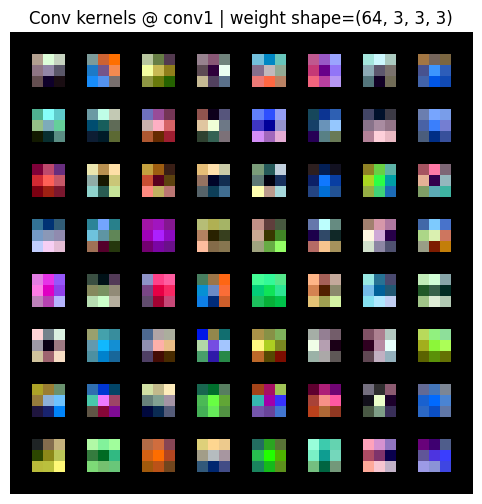

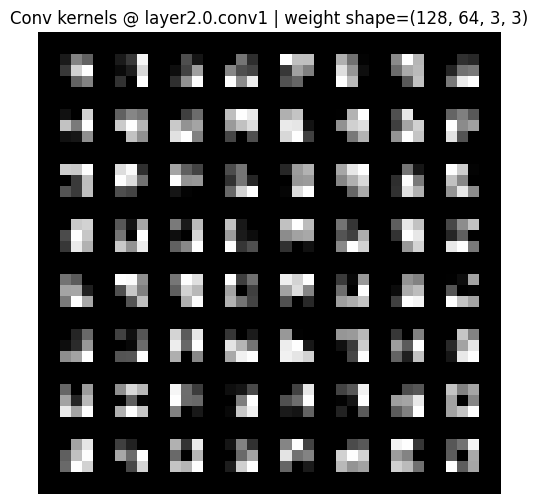

In [11]:
def show_conv_kernels(model, layer_name='conv1', max_kernels=64):
    layer = get_module_by_name(model, layer_name)  # target layer
    assert isinstance(layer, nn.Conv2d)  # conv인지 확인
    w = layer.weight.detach().cpu()  # (O,I,kH,kW)
    O, I, kH, kW = w.shape  # shape 분해
    K = min(O, max_kernels)  # 시각화할 커널 수 제한

    imgs = []  # 커널 이미지 리스트
    for o in range(K):
        ker = w[o]  # (I,kH,kW)
        if I == 3:  # RGB 입력이면 그대로 시각화 가능
            img = (ker - ker.min()) / (ker.max() - ker.min() + 1e-6)  # 0~1 정규화
            imgs.append(img)  # (3,kH,kW)
        else:  # 입력 채널이 많으면 평균내서 2D로 시각화
            img2d = ker.mean(dim=0, keepdim=True)  # (1,kH,kW)
            img2d = (img2d - img2d.min()) / (img2d.max() - img2d.min() + 1e-6)  # 정규화
            imgs.append(img2d)  # (1,kH,kW)

    imgs = torch.stack(imgs, dim=0)  # (K,C,kH,kW)
    grid = torchvision.utils.make_grid(imgs, nrow=8, padding=2)  # grid 생성
    plt.figure(figsize=(12,6))
    if grid.ndim == 3 and grid.shape[0] in (3,4):  # CHW면 HWC로 표시
        plt.imshow(grid.permute(1,2,0))
    else:  # 1채널이면 grayscale
        plt.imshow(grid.squeeze(0), cmap='gray')
    plt.title(f'Conv kernels @ {layer_name} | weight shape={tuple(w.shape)}')
    plt.axis('off')
    plt.show()

show_conv_kernels(model, 'conv1', max_kernels=64)  # 첫 레이어 커널
show_conv_kernels(model, 'layer2.0.conv1', max_kernels=64)  # 중간 레이어 커널(평균 시각화)


---
## 9) Grad-CAM 시각화 — Top-K 정분류/오분류 (원본 + Overlay)
- **목적:** 모델이 특정 예측을 할 때 **어느 영역을 근거로 삼는지**를 시각화합니다.
- **관찰 포인트**
  - 정분류 고신뢰 Top-K: 모델이 '무엇을 제대로 보고 맞추는지'
  - 오분류 고신뢰 Top-K: 모델이 '어디를 보고 틀리는지'


Top-K correct indices: [6955, 3196, 6621, 7965, 5798, 4564, 1071, 2365]
Top-K wrong indices: [5548, 9227, 2405, 7000, 4965, 4276, 1577, 3957]


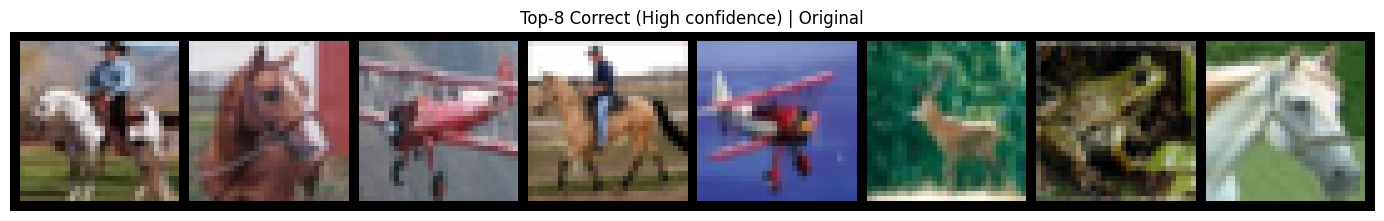

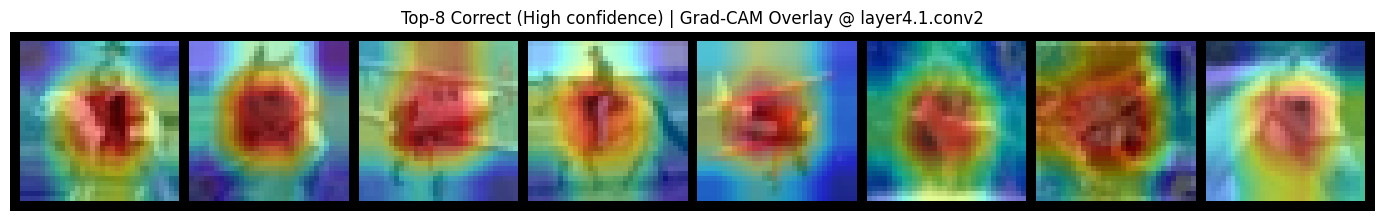

GT=horse | P=horse(1.00) | idx=6955
GT=horse | P=horse(1.00) | idx=3196
GT=airplane | P=airplane(1.00) | idx=6621
GT=horse | P=horse(1.00) | idx=7965
GT=airplane | P=airplane(1.00) | idx=5798
GT=deer | P=deer(1.00) | idx=4564
GT=frog | P=frog(1.00) | idx=1071
GT=horse | P=horse(1.00) | idx=2365


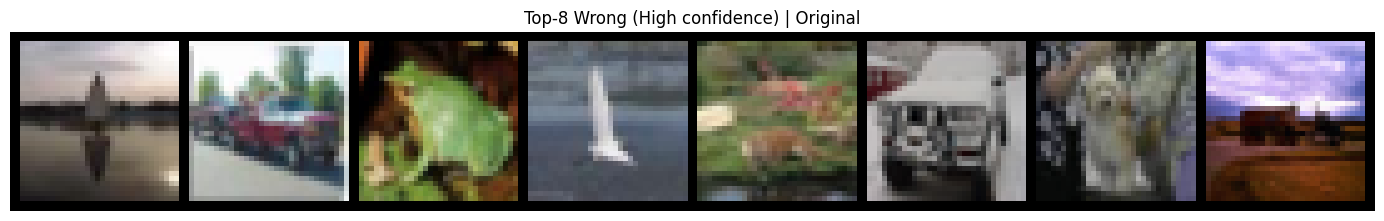

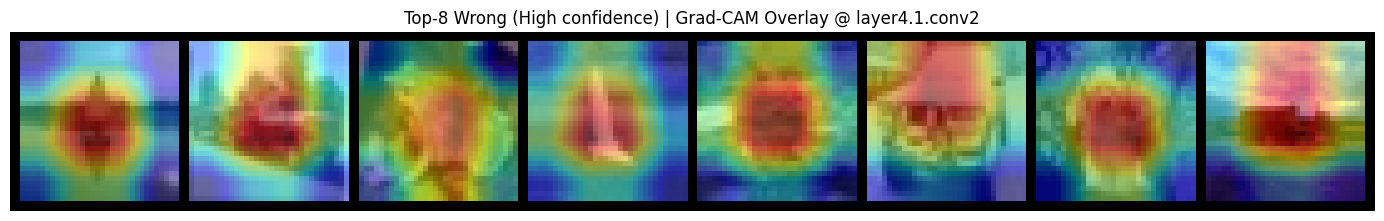

GT=ship | P=airplane(1.00) | idx=5548
GT=automobile | P=truck(1.00) | idx=9227
GT=cat | P=frog(1.00) | idx=2405
GT=bird | P=ship(1.00) | idx=7000
GT=cat | P=deer(1.00) | idx=4965
GT=truck | P=automobile(1.00) | idx=4276
GT=dog | P=cat(1.00) | idx=1577
GT=truck | P=airplane(1.00) | idx=3957


In [12]:
class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model  # 대상 모델
        self.target_layer = target_layer  # CAM을 뽑을 레이어
        self.activ = None  # forward activation 저장
        self.grad = None  # backward gradient 저장
        self.h1 = target_layer.register_forward_hook(self._forward_hook)  # forward hook
        self.h2 = target_layer.register_full_backward_hook(self._backward_hook)  # backward hook

    def _forward_hook(self, module, inp, out):
        self.activ = out  # (B,C,H,W) activation

    def _backward_hook(self, module, grad_input, grad_output):
        self.grad = grad_output[0]  # (B,C,H,W) gradient

    def remove(self):
        self.h1.remove()  # hook 제거
        self.h2.remove()  # hook 제거

    def __call__(self, x: torch.Tensor, class_idx: int = None):
        self.model.zero_grad(set_to_none=True)  # grad 초기화
        logits = self.model(x)  # forward
        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())  # 예측 클래스 사용
        score = logits[:, class_idx].sum()  # 해당 클래스 점수
        score.backward(retain_graph=False)  # backward로 grad 얻기

        w = self.grad.mean(dim=(2,3), keepdim=True)  # 채널별 중요도(gradient 평균)
        cam = (w * self.activ).sum(dim=1, keepdim=True)  # 중요도 가중합 [B,H, W]
        cam = F.relu(cam)  # ReLU로 양의 기여만
        cam = cam - cam.min()  # min shift
        cam = cam / (cam.max() + 1e-6)  # 0~1 정규화
        return cam.detach(), logits.detach(), class_idx  # cam/logits/class 반환 [B, 1, H, W] / [B, K] / 1

def overlay_heatmap_on_image(img_chw: torch.Tensor, heat_hw: torch.Tensor, alpha=0.45):
    img = img_chw.permute(1,2,0).cpu().numpy()  # CHW -> HWC
    heat = heat_hw.cpu().numpy()  # heatmap to numpy
    cmap = plt.get_cmap('jet')  # 컬러맵
    heat_rgb = cmap(heat)[...,:3]  # heatmap을 RGB로
    out = (1-alpha)*img + alpha*heat_rgb  # overlay
    return np.clip(out, 0, 1)  # [0,1]로 clip

@torch.no_grad()
def predict_all_with_conf(model, loader):
    model.eval()  # eval 모드
    preds, confs, labels = [], [], []  # 누적 리스트
    for x, y in loader:
        x = x.to(device)  # GPU 이동
        y = y.to(device)  # GPU 이동
        p, c, _ = predict_batch(model, x)  # 예측
        preds.append(p.cpu())  # CPU 누적
        confs.append(c.cpu())  # CPU 누적
        labels.append(y.cpu())  # CPU 누적
    return torch.cat(preds), torch.cat(confs), torch.cat(labels)  # concat

# Top-K 선택(정분류/오분류 각각)
K = 8  # 묶음 크기(원하면 변경)
preds_all2, confs_all2, labels_all2 = predict_all_with_conf(model, test_loader)  # test 전체 예측
correct_mask = (preds_all2 == labels_all2)  # 정분류 마스크
wrong_mask = ~correct_mask  # 오분류 마스크

corr_idx = correct_mask.nonzero(as_tuple=False).squeeze(1)  # 정분류 인덱스
corr_sorted = corr_idx[torch.argsort(confs_all2[corr_idx], descending=True)]  # conf 내림차순 정렬
corr_top = corr_sorted[:K]  # Top-K 정분류

wrong_idx = wrong_mask.nonzero(as_tuple=False).squeeze(1)  # 오분류 인덱스
wrong_sorted = wrong_idx[torch.argsort(confs_all2[wrong_idx], descending=True)]  # conf 내림차순 정렬
wrong_top = wrong_sorted[:K]  # Top-K 오분류

print('Top-K correct indices:', corr_top.tolist())  # 출력
print('Top-K wrong indices:', wrong_top.tolist())  # 출력

# Grad-CAM 레이어(일반적으로 마지막 conv 추천)
cam_layer_name = 'layer4.1.conv2'  # CAM 대상 레이어
cam_layer = get_module_by_name(model, cam_layer_name)  # 레이어 객체 얻기
gcam = GradCAM(model, cam_layer)  # GradCAM 인스턴스

def gradcam_for_indices(indices, title):
    overlays = []  # overlay 이미지 리스트(CHW tensor)
    originals = []  # 원본 이미지 리스트(CHW tensor)
    captions = []  # 텍스트 정보 리스트

    for idx in indices.tolist():
        x, y = test_set[idx]  # 원본 샘플(단일)
        x_in = x.unsqueeze(0).to(device)  # 배치화 + GPU 이동

        cam, logits, used_class = gcam(x_in, class_idx=None)  # CAM 계산(예측 클래스 기준)
        prob = F.softmax(logits, dim=1)[0, used_class].item()  # 예측 확률
        pred_name = class_names[used_class]  # 예측 클래스명
        gt_name = class_names[y]  # GT 클래스명

        img0 = denorm(x.unsqueeze(0)).squeeze(0).clamp(0,1)  # 원본(역정규화)
        originals.append(img0.cpu())  # 원본 저장

        cam_resized = F.interpolate(cam, size=(32,32), mode='bilinear', align_corners=False)[0,0].cpu()  # 입력 크기로 resize
        overlay = overlay_heatmap_on_image(img0, cam_resized, alpha=0.45)  # overlay 생성
        overlays.append(torch.from_numpy(overlay).permute(2,0,1))  # HWC -> CHW 저장

        captions.append(f"GT={gt_name} | P={pred_name}({prob:.2f}) | idx={idx}")  # 캡션 저장

    # (1) 원본 그리드
    orig_grid = torchvision.utils.make_grid(torch.stack(originals, dim=0), nrow=len(indices), padding=2)  # original grid
    plt.figure(figsize=(2.2*len(indices), 3))
    plt.imshow(orig_grid.permute(1,2,0))  # 표시
    plt.axis('off')
    plt.title(title + " | Original")
    plt.show()

    # (2) Grad-CAM Overlay 그리드
    over_grid = torchvision.utils.make_grid(torch.stack(overlays, dim=0), nrow=len(indices), padding=2)  # overlay grid
    plt.figure(figsize=(2.2*len(indices), 3))
    plt.imshow(over_grid.permute(1,2,0))  # 표시
    plt.axis('off')
    plt.title(title + f" | Grad-CAM Overlay @ {cam_layer_name}")
    plt.show()

    for c in captions:
        print(c)  # 텍스트로도 출력

gradcam_for_indices(corr_top, f"Top-{K} Correct (High confidence)")  # 정분류 묶음
gradcam_for_indices(wrong_top, f"Top-{K} Wrong (High confidence)")  # 오분류 묶음
gcam.remove()  # hook 해제


---
## 10) (추가 실습) Receptive Field 근사 계산 — '이 feature는 입력에서 얼마나 넓게 보나?'

### Receptive field란?
CNN에서 어떤 feature map의 한 위치가 **입력 이미지의 어느 범위를 보고** 계산되었는지를 나타내는 값입니다.
- 직관적으로는 **"이 뉴런이 입력에서 커버하는 시야 크기"** 입니다.
- 네트워크가 깊어질수록 receptive field가 커져서 더 넓은 문맥(context)을 반영합니다.

### 왜 실습을 진행하면서 유용한가?
- 얕은 레이어: 작은 receptive field → edge/texture 같은 로컬 특징
- 깊은 레이어: 큰 receptive field → 객체의 부분/형태/의미적 단서

### 이 코드의 근사 계산 규칙
`rf`(receptive field 크기), `jump`(현재 feature map 한 칸이 입력에서 몇 픽셀 이동인지)을 누적합니다.
- 커널 크기 `k`, stride `s`인 conv를 거치면
  - `rf_new = rf + (k - 1) * jump`
  - `jump_new = jump * s`

> 결과는 엄밀한 해석보다 **직관 전달용**(깊어질수록 rf 증가)으로 보세요.


In [13]:
def rf_update(rf, jump, k, s):
    rf_new = rf + (k - 1) * jump  # receptive field 누적
    jump_new = jump * s  # stride 누적
    return rf_new, jump_new

def estimate_resnet18_cifar_rf():
    rf, jump = 1, 1  # 초기 rf=1, jump=1
    rf, jump = rf_update(rf, jump, k=3, s=1)  # conv1(3x3, stride1)
    for _ in range(2*2):  # layer1: 2 blocks * 2 conv
        rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=2)  # layer2 첫 conv(stride2)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=2)  # layer3 첫 conv(stride2)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=2)  # layer4 첫 conv(stride2)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    rf, jump = rf_update(rf, jump, k=3, s=1)
    return rf, jump

rf, jump = estimate_resnet18_cifar_rf()  # rf/jump 계산
print('Estimated receptive field at last conv stage:', rf)  # rf 출력
print('Effective stride (jump):', jump)  # jump 출력


Estimated receptive field at last conv stage: 109
Effective stride (jump): 8


---
## 11) (추가 실습) Embedding 시각화 (t-SNE)
- **목적:** 마지막 FC 직전 feature(예: 512-d)가 클래스별로 어떻게 분리되는지 확인합니다.
- **관찰 포인트**
    - CNN이 'feature space'에서 클래스를 구분하도록 representation을 만든다는 직관 제공


features: (2000, 512)


  File "C:\ProgramData\miniconda3\envs\env_aias_test\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\miniconda3\envs\env_aias_test\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\miniconda3\envs\env_aias_test\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\miniconda3\envs\env_aias_test\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


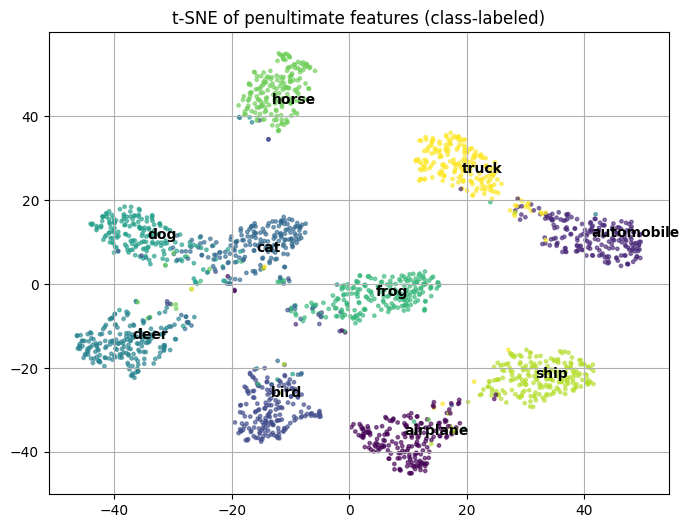

In [14]:
import warnings

# 특정 UserWarning만 무시
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

@torch.no_grad()
def extract_penultimate_features(model, loader, max_samples=2000):
    model.eval()  # eval 모드
    feats, labs = [], []  # 누적
    storage = {}  # hook 저장소

    def hook(m, i, o):
        storage['f'] = torch.flatten(o, 1).detach().cpu()  # avgpool output -> flatten

    h = model.avgpool.register_forward_hook(hook)  # avgpool에 hook
    n = 0  # 샘플 수
    for x, y in loader:
        x = x.to(device)  # GPU
        _ = model(x)  # forward (hook에 feature 저장)
        feats.append(storage['f'])  # feature 누적
        labs.append(y)  # label 누적
        n += x.size(0)  # 샘플 수 누적
        if n >= max_samples:
            break  # 샘플 제한
    h.remove()  # hook 제거

    X = torch.cat(feats, dim=0)[:max_samples].numpy()  # feature matrix
    Y = torch.cat(labs, dim=0)[:max_samples].numpy()  # labels
    return X, Y

X_feat, y_feat = extract_penultimate_features(model, test_loader, max_samples=2000)  # feature 추출
print('features:', X_feat.shape)  # shape 출력

try:
    from sklearn.manifold import TSNE  # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)  # 설정
    X_2d = tsne.fit_transform(X_feat)  # 2D로 축소

    plt.figure(figsize=(8,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], s=6, c=y_feat, alpha=0.6)  # scatter
    # 클래스별 중심(centroid)에 클래스 이름 표시
    for cls in range(num_classes):
        idx = (y_feat == cls)
        if idx.sum() > 0:
            cx = X_2d[idx, 0].mean()
            cy = X_2d[idx, 1].mean()
            plt.text(cx, cy, class_names[cls], fontsize=10, weight='bold')
    plt.title('t-SNE of penultimate features (class-labeled)')
    plt.grid(True)
    plt.show()
except Exception as e:
    print('TSNE failed:', e)  # 에러 출력
    print('Note: pip install scikit-learn')  # 설치 안내


---
## 12) (추가 실습) ONNX Export + 구조 출력 (Netron 비교)
- **목적:** 모델을 ONNX로 내보내 Netron에서 그래프 형태로 확인합니다.
- **관찰 포인트**
    - `print(model)` 요약 정보와 Netron 그래프가 어떻게 매칭되는지 비교해보기


In [15]:
# 필요 시 설치 (환경에 따라 주석 해제)
# !pip -q install onnx onnxruntime torchinfo

import torch
from IPython.display import display
from torchinfo import summary

try:
    print("\n=== torchinfo summary (input_size 포함) ===")
    summary_result = summary(
        model,
        input_size=(1, 3, 32, 32),
        device=str(device),
        verbose=2,
    )
except Exception as e:
    print("\n(torchinfo summary skipped) Reason:", e)
    print("Note: pip install torchinfo")

onnx_path = 'resnet18_cifar10.onnx'
dummy = torch.randn(1, 3, 32, 32, device=device)
model.eval()

try:
    torch.onnx.export(
        model,
        dummy,
        onnx_path,
        input_names=['input'],
        output_names=['logits'],
        opset_version=17,
        do_constant_folding=True,
        dynamic_axes={'input': {0: 'B'}, 'logits': {0: 'B'}},
    )
    print("\nSaved ONNX:", onnx_path)
    print("Netron에서 위 구조와 레이어/연결이 어떻게 대응되는지 비교해보세요.")
except Exception as e:
    print("ONNX export failed:", e)
    print("Note: pip install onnx")




=== torchinfo summary (input_size 포함) ===
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
│    └─weight                                                      └─1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
│    └─weight                                                      ├─64
│    └─bias                                                        └─64
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─Identity: 1-4                          [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 64, 32, 32]           --
│    └─0.conv1.weight                                              ├─36,864
│    └─0.bn1.weight                                                ├─64
│    └─0.bn1.bias                                                  ├─64
│    └─0.conv2.weig